In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             confusion_matrix, roc_curve, classification_report)
import matplotlib.pyplot as plt
from collections import Counter


In [56]:
# 1. Load the dataset
df = pd.read_csv("smart_logistics_dataset.csv")
df.head()

,Timestamp,Asset_ID,Latitude,Longitude,Inventory_Level,Shipment_Status,Temperature,Humidity,Traffic_Status,Waiting_Time,User_Transaction_Amount,User_Purchase_Frequency,Logistics_Delay_Reason,Asset_Utilization,Demand_Forecast,Logistics_Delay
0,2024-03-20 00:11:14,Truck_7,-65.7383,11.2497,390,Delayed,27.0,67.8,Detour,38,320,4,NaN,60.1,285,1
1,2024-10-30 07:53:51,Truck_6,22.2748,-131.7086,491,In Transit,22.5,54.3,Heavy,16,439,7,Weather,80.9,174,1
2,2024-07-29 18:42:48,Truck_10,54.9232,79.5455,190,In Transit,25.2,62.2,Detour,34,355,3,NaN,99.2,260,0
3,2024-10-28 00:50:54,Truck_9,42.3900,-1.4788,330,Delivered,25.4,52.3,Heavy,37,227,5,Traffic,97.4,160,1
4,2024-09-27 15:52:58,Truck_7,-65.8477,47.9468,480,Delayed,20.5,57.2,Clear,56,197,6,NaN,71.6,270,1


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Timestamp                1000 non-null   object 
 1   Asset_ID                 1000 non-null   object 
 2   Latitude                 1000 non-null   float64
 3   Longitude                1000 non-null   float64
 4   Inventory_Level          1000 non-null   int64  
 5   Shipment_Status          1000 non-null   object 
 6   Temperature              1000 non-null   float64
 7   Humidity                 1000 non-null   float64
 8   Traffic_Status           1000 non-null   object 
 9   Waiting_Time             1000 non-null   int64  
 10  User_Transaction_Amount  1000 non-null   int64  
 11  User_Purchase_Frequency  1000 non-null   int64  
 12  Logistics_Delay_Reason   737 non-null    object 
 13  Asset_Utilization        1000 non-null   float64
 14  Demand_Forecast          

In [58]:
df.shape

(1000, 16)

In [59]:
missing = df.isnull().sum().sort_values(ascending=False)
missing


Logistics_Delay_Reason     263
Timestamp                    0
Asset_ID                     0
Latitude                     0
Longitude                    0
Inventory_Level              0
Shipment_Status              0
Temperature                  0
Humidity                     0
Traffic_Status               0
Waiting_Time                 0
User_Transaction_Amount      0
User_Purchase_Frequency      0
Asset_Utilization            0
Demand_Forecast              0
Logistics_Delay              0
dtype: int64

In [60]:
missing_val = (df.isnull().mean()*100).sort_values(ascending=False)
missing_val

Logistics_Delay_Reason     26.3
Timestamp                   0.0
Asset_ID                    0.0
Latitude                    0.0
Longitude                   0.0
Inventory_Level             0.0
Shipment_Status             0.0
Temperature                 0.0
Humidity                    0.0
Traffic_Status              0.0
Waiting_Time                0.0
User_Transaction_Amount     0.0
User_Purchase_Frequency     0.0
Asset_Utilization           0.0
Demand_Forecast             0.0
Logistics_Delay             0.0
dtype: float64

In [61]:
missing_df = pd.concat([missing, missing_val], axis=1)
missing_df.columns = ["missing_count", "missing_pct"]

In [62]:
df.duplicated().sum()

0

In [63]:
df.describe()

,Latitude,Longitude,Inventory_Level,Temperature,Humidity,Waiting_Time,User_Transaction_Amount,User_Purchase_Frequency,Asset_Utilization,Demand_Forecast,Logistics_Delay
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-1.360093,0.837049,297.915000,23.893900,65.042200,35.062000,299.055000,5.513000,79.599100,199.284000,0.566000
std,51.997183,104.843618,113.554773,3.322178,8.753765,14.477768,117.787792,2.935379,11.631153,59.920847,0.495873
min,-89.791500,-179.820200,100.000000,18.000000,50.000000,10.000000,100.000000,1.000000,60.000000,100.000000,0.000000
25%,-46.167975,-88.448075,201.000000,21.200000,57.200000,23.000000,191.750000,3.000000,69.475000,144.000000,0.000000
50%,-4.503150,0.678300,299.000000,23.800000,65.200000,35.000000,301.500000,6.000000,79.250000,202.000000,1.000000
75%,44.502800,88.156450,399.000000,26.600000,72.400000,49.000000,405.000000,8.000000,89.425000,251.250000,1.000000
max,89.870100,179.923700,500.000000,30.000000,80.000000,60.000000,500.000000,10.000000,100.000000,300.000000,1.000000


In [64]:
# 3. Convert Timestamp to datetime and create time-based features
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df['year'] = df['Timestamp'].dt.year
df['month'] = df['Timestamp'].dt.month
df['day'] = df['Timestamp'].dt.day
df['hour'] = df['Timestamp'].dt.hour
df['dayofweek'] = df['Timestamp'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)

In [65]:
# 4. Clean/normalize column names (strip and replace spaces)
df.columns = [c.strip().replace(' ', '_') for c in df.columns]

In [66]:
# 5. Basic cleaning decisions (automated):
# - Fill numeric missing values with median
# - Fill categorical missing values with 'Unknown'
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number, 'datetime']).columns.tolist()
# remove target from features list if present
if 'Logistics_Delay' in num_cols:
    num_cols.remove('Logistics_Delay')

In [67]:
# Imputation + encoding pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


In [68]:
# For categorical: use OneHot for low-cardinality, Ordinal for high-card
# Determine cardinality
low_cardinality = [c for c in cat_cols if df[c].nunique() <= 12 and c!='Logistics_Delay_Reason']
high_cardinality = [c for c in cat_cols if df[c].nunique() > 12 and c!='Logistics_Delay_Reason']

In [69]:
# We'll impute categorical with 'Unknown' then OneHot for low_card, Ordinal for high_card
categorical_low_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


In [70]:
categorical_high_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])


In [71]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat_low', categorical_low_pipeline, low_cardinality),
    ('cat_high', categorical_high_pipeline, high_cardinality),
], remainder='drop', sparse_threshold=0)

In [72]:
# 6. Feature engineering: interaction features and bins
# Temperature x Humidity interaction
df['temp_humidity'] = df['Temperature'] * df['Humidity'] if 'Temperature' in df.columns and 'Humidity' in df.columns else np.nan
# Waiting time bins
if 'Waiting_Time' in df.columns:
    df['waiting_time_bin'] = pd.cut(df['Waiting_Time'], bins=[-1,5,15,30,60,99999], labels=['0-5','6-15','16-30','31-60','60+'])
# Asset utilization buckets
if 'Asset_Utilization' in df.columns:
    df['asset_util_bucket'] = pd.cut(df['Asset_Utilization'], bins=[-1,20,50,80,100], labels=['very_low','low','moderate','high'])


In [73]:
# 7. Target variable and simple class balance check
from IPython.display import display

if 'Logistics_Delay' not in df.columns:
    raise ValueError("Target column 'Logistics_Delay' not found in dataset. Please ensure it's present.")
target = 'Logistics_Delay'
print("Target distribution:")

display(
    df[target].value_counts()
    .rename_axis('Logistics_Delay')
    .reset_index(name='count')
)



Target distribution:


,Logistics_Delay,count
0,1,566
1,0,434


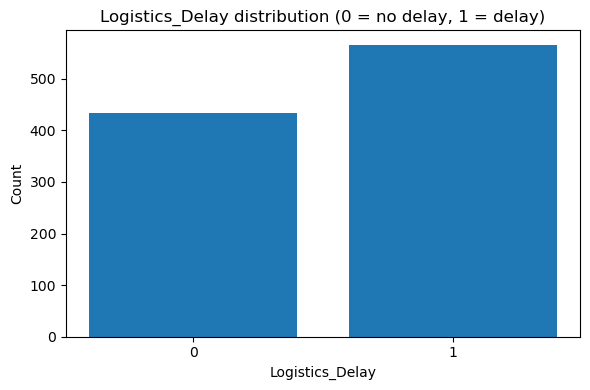

In [74]:
# 8. Quick EDA visualizations (matplotlib only, single plot per chart)
# Plot 1: Target distribution pie/bar
plt.figure(figsize=(6,4))
counts = df[target].value_counts().sort_index()
plt.bar(counts.index.astype(str), counts.values)
plt.title("Logistics_Delay distribution (0 = no delay, 1 = delay)")
plt.xlabel("Logistics_Delay")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

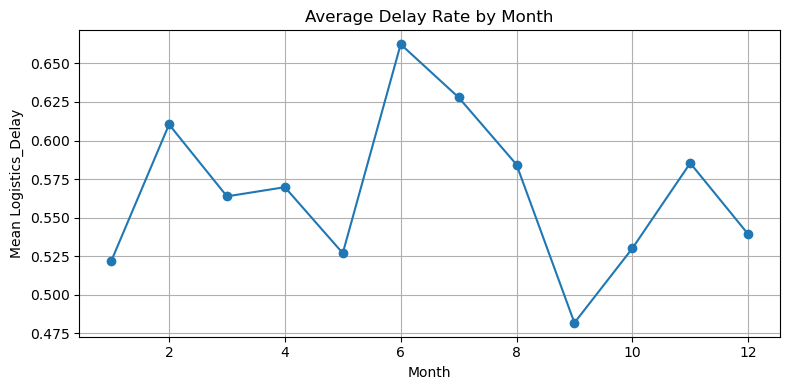

In [75]:
# Plot 2: Delay by month
if 'month' in df.columns:
    month_counts = df.groupby('month')[target].mean()
    plt.figure(figsize=(8,4))
    plt.plot(month_counts.index, month_counts.values, marker='o')
    plt.title("Average Delay Rate by Month")
    plt.xlabel("Month")
    plt.ylabel("Mean Logistics_Delay")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

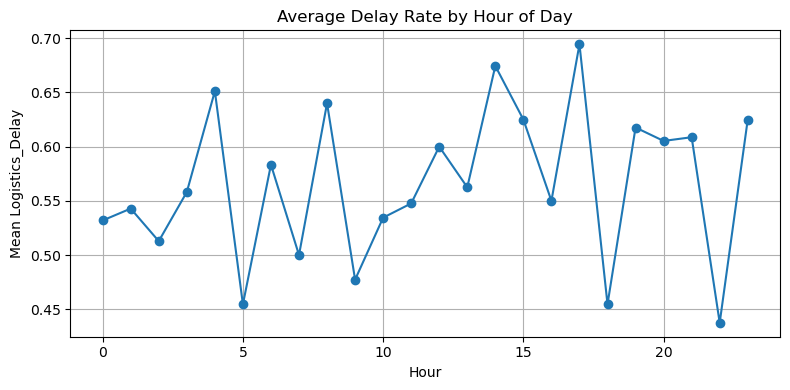

In [76]:
# Plot 3: Delay by hour of day
if 'hour' in df.columns:
    hour_counts = df.groupby('hour')[target].mean()
    plt.figure(figsize=(8,4))
    plt.plot(hour_counts.index, hour_counts.values, marker='o')
    plt.title("Average Delay Rate by Hour of Day")
    plt.xlabel("Hour")
    plt.ylabel("Mean Logistics_Delay")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

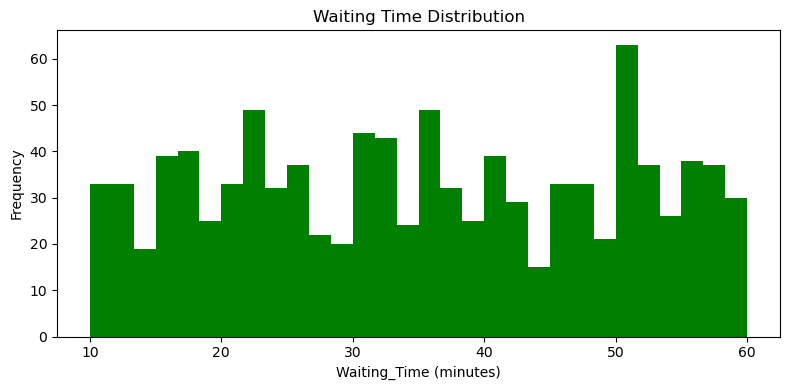

In [77]:
# Plot 4: Waiting time distribution (hist)
if 'Waiting_Time' in df.columns:
    plt.figure(figsize=(8,4))
    plt.hist(df['Waiting_Time'].dropna(), bins=30,color = 'green')
    plt.title("Waiting Time Distribution")
    plt.xlabel("Waiting_Time (minutes)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

In [78]:
# 9. Prepare features for modeling

feature_cols = [
    'Latitude', 'Longitude', 'Inventory_Level', 'Temperature', 'Humidity',
    'Waiting_Time', 'User_Transaction_Amount', 'User_Purchase_Frequency',
    'Asset_Utilization', 'Demand_Forecast',
    'year', 'month', 'day', 'hour', 'dayofweek', 'is_weekend',
    'temp_humidity', 'waiting_time_bin', 'asset_util_bucket',
    'Shipment_Status', 'Traffic_Status', 'Logistics_Delay_Reason'
]

# Keep only columns that actually exist in df AND remove duplicates automatically
feature_cols = [c for i, c in enumerate(feature_cols) if c in df.columns and c not in feature_cols[:i]]

print("Final feature list:", feature_cols)


Final feature list: ['Latitude', 'Longitude', 'Inventory_Level', 'Temperature', 'Humidity', 'Waiting_Time', 'User_Transaction_Amount', 'User_Purchase_Frequency', 'Asset_Utilization', 'Demand_Forecast', 'year', 'month', 'day', 'hour', 'dayofweek', 'is_weekend', 'temp_humidity', 'waiting_time_bin', 'asset_util_bucket', 'Shipment_Status', 'Traffic_Status', 'Logistics_Delay_Reason']


In [79]:
# Fill any remaining missing values in chosen features for pipeline to handle
X = df[feature_cols].copy()
y = df[target].copy()

# Convert object type columns in X to string (to avoid pandas issues)
for c in X.select_dtypes(include=['object','category']).columns:
    X[c] = X[c].astype(str)

In [80]:
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(exclude=['number']).columns.tolist()

print("Numeric:", num_cols)
print("Categorical:", cat_cols)


Numeric: ['Latitude', 'Longitude', 'Inventory_Level', 'Temperature', 'Humidity', 'Waiting_Time', 'User_Transaction_Amount', 'User_Purchase_Frequency', 'Asset_Utilization', 'Demand_Forecast', 'year', 'month', 'day', 'hour', 'dayofweek', 'is_weekend', 'temp_humidity']
Categorical: ['waiting_time_bin', 'asset_util_bucket', 'Shipment_Status', 'Traffic_Status', 'Logistics_Delay_Reason']


In [81]:

low_card = [c for c in cat_cols if X[c].nunique() <= 12]
high_card = [c for c in cat_cols if X[c].nunique() > 12]

In [82]:

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_low_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

cat_high_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])


transformers = []
if num_cols: transformers.append(('num', num_pipeline, num_cols))
if low_card: transformers.append(('low', cat_low_pipeline, low_card))
if high_card: transformers.append(('high', cat_high_pipeline, high_card))

preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')

In [83]:

# Train-test split (stratify by target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [84]:
# Fit preprocessing on train then transform both sets
preprocessor.fit(X_train)
X_train_trans = preprocessor.transform(X_train)
X_test_trans = preprocessor.transform(X_test)

In [87]:
# numeric
num_feat_names = num_cols

# onehot
onehot_feat_names = []
if low_card:
    onehot_feat_names = preprocessor.named_transformers_['low'].named_steps['onehot'].get_feature_names_out(low_card).tolist()

# ordinal
ord_feat_names = high_card

all_features = num_feat_names + onehot_feat_names + ord_feat_names


In [88]:
X_train_df = pd.DataFrame(X_train_trans, columns=all_features)
X_test_df = pd.DataFrame(X_test_trans, columns=all_features)

display(X_train_df.head())


,Latitude,Longitude,Inventory_Level,Temperature,Humidity,Waiting_Time,User_Transaction_Amount,User_Purchase_Frequency,Asset_Utilization,Demand_Forecast,...,Shipment_Status_Delayed,Shipment_Status_Delivered,Shipment_Status_In Transit,Traffic_Status_Clear,Traffic_Status_Detour,Traffic_Status_Heavy,Logistics_Delay_Reason_Mechanical Failure,Logistics_Delay_Reason_Traffic,Logistics_Delay_Reason_Weather,Logistics_Delay_Reason_nan
0,0.282856,0.245230,1.519449,-0.347750,-1.371946,-0.344732,0.761649,0.186851,0.624184,0.516653,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-1.372451,1.277366,1.616748,-0.589689,0.771808,1.640324,-0.614075,1.574144,-0.896135,-0.815892,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.060728,-1.649056,-1.487960,1.103886,-0.895556,0.065969,1.538132,-0.159972,-1.241662,-1.015774,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1.055583,-1.413949,0.228032,-1.164295,-0.963612,-1.234585,-0.327114,0.186851,-1.042984,-0.649324,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.819019,1.277223,-0.196543,-0.317508,-1.383288,-1.166135,-1.643759,-0.506795,-0.723372,-0.182933,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [96]:
#12. Train Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=200, random_state=42)
}

model_results = []

for name, model in models.items():
    model.fit(X_train_df, y_train)
    pred = model.predict(X_test_df)
    proba = model.predict_proba(X_test_df)[:,1]
    
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, pred),
        "Precision": precision_score(y_test, pred),
        "Recall": recall_score(y_test, pred),
        "F1": f1_score(y_test, pred),
        "ROC_AUC": roc_auc_score(y_test, proba)
    })

results_df = pd.DataFrame(results)
display(results_df)



,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression,1.0,1.0,1.0,1.0,1.0
1,RandomForest,1.0,1.0,1.0,1.0,1.0
2,GradientBoosting,1.0,1.0,1.0,1.0,1.0
3,Logistic Regression,1.0,1.0,1.0,1.0,1.0
4,RandomForest,1.0,1.0,1.0,1.0,1.0
5,GradientBoosting,1.0,1.0,1.0,1.0,1.0


In [91]:
#13. Hyperparameter Tuning — RandomForest
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42)

param_dist = {
    "n_estimators": [200, 300, 500],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

rf_search = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=20, scoring="f1", cv=3, n_jobs=-1, random_state=42
)

rf_search.fit(X_train_df, y_train)

print("Best RF Params:", rf_search.best_params_)


Best RF Params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 30}


In [92]:
#14. Hyperparameter Tuning — GradientBoosting
gb = GradientBoostingClassifier(random_state=42)

gb_params = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [2, 3, 4]
}

gb_search = GridSearchCV(
    gb, param_grid=gb_params,
    scoring="f1", cv=3, n_jobs=-1
)

gb_search.fit(X_train_df, y_train)

print("Best GB Params:", gb_search.best_params_)


Best GB Params: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100}


In [93]:
#15. Evaluate Tuned Models
def eval_model(model):
    pred = model.predict(X_test_df)
    proba = model.predict_proba(X_test_df)[:,1]
    return {
        "Accuracy": accuracy_score(y_test, pred),
        "Precision": precision_score(y_test, pred),
        "Recall": recall_score(y_test, pred),
        "F1": f1_score(y_test, pred),
        "ROC_AUC": roc_auc_score(y_test, proba)
    }

rf_tuned_results = eval_model(rf_search.best_estimator_)
gb_tuned_results = eval_model(gb_search.best_estimator_)

display(pd.DataFrame([
    {"Model": "RandomForest Tuned", **rf_tuned_results},
    {"Model": "GradientBoosting Tuned", **gb_tuned_results}
]))


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,RandomForest Tuned,1.0,1.0,1.0,1.0,1.0
1,GradientBoosting Tuned,1.0,1.0,1.0,1.0,1.0
